In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as sk_cluster
from sklearn import metrics
from scipy import cluster
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

%matplotlib inline

In [2]:
data = pd.read_csv("ABT_ECH_START.csv", sep=";")
del data["CODE_CLT"]
del data["C_DEBLOC_CREDIT_MNT"]
del data["C_DEBLOC_CREDIT_NB"]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9996 entries, 0 to 9995
Data columns (total 22 columns):
C_CHEQUE_MNT         9996 non-null float64
C_CHEQUE_NB          9996 non-null float64
C_MNT                9996 non-null float64
C_NB                 9996 non-null float64
C_VERS_ESPECE_MNT    9996 non-null float64
C_VERS_ESPECE_NB     9996 non-null float64
C_VIREMENT_MNT       9996 non-null float64
C_VIREMENT_NB        9996 non-null float64
D_CHEQUE_MNT         9996 non-null float64
D_CHEQUE_NB          9996 non-null float64
D_MNT                9996 non-null float64
D_NB                 9996 non-null float64
D_PMNT_TPE_MNT       9996 non-null float64
D_PMNT_TPE_NB        9996 non-null float64
D_REMB_CREDIT_MNT    9996 non-null float64
D_REMB_CREDIT_NB     9996 non-null float64
D_RET_DAB_MNT        9996 non-null float64
D_RET_DAB_NB         9996 non-null float64
D_RET_ESPECE_MNT     9996 non-null float64
D_RET_ESPECE_NB      9996 non-null float64
D_VIREMENT_MNT       9996 non-nul

In [3]:
data["REVENU"] = data["C_CHEQUE_MNT"] + data["C_VERS_ESPECE_MNT"] + data["C_VIREMENT_MNT"]
data["C_TAUX_CHEQUE"] = round(data["C_CHEQUE_MNT"]/data["REVENU"],4)*100
data["C_TAUX_VERS_ESPECE"] = round(data["C_VERS_ESPECE_MNT"]/data["REVENU"],4)*100
data["C_TAUX_VIREMENT"] = round(data["C_VIREMENT_MNT"]/data["REVENU"],4)*100
data["D_TAUX_CHEQUE"] = round(data["D_CHEQUE_MNT"]/data["D_MNT"],4)*100
data["D_TAUX_RET_ESPECE"] = round(data["D_RET_ESPECE_MNT"]/data["D_MNT"],4)*100
data["D_TAUX_VIREMENT"] = round(data["D_VIREMENT_MNT"]/data["D_MNT"],4)*100
data["D_TAUX_DAB"] = round(data["D_RET_DAB_MNT"]/data["D_MNT"],4)*100
data["D_TAUX_TPE"] = round(data["D_PMNT_TPE_MNT"]/data["D_MNT"],4)*100
data["D_TAUX_REMB"] = round(data["D_REMB_CREDIT_MNT"]/data["D_MNT"],4)*100
data.fillna(0, inplace=True)

In [4]:
df = data[["C_TAUX_CHEQUE", "C_TAUX_VERS_ESPECE", "C_TAUX_VIREMENT", "D_TAUX_CHEQUE",
           "D_TAUX_RET_ESPECE", "D_TAUX_VIREMENT", "D_TAUX_DAB", "D_TAUX_TPE", "D_TAUX_REMB"]]

def winsorize_series(s):
    q = s.quantile([0.00, 0.95])
    if isinstance(q, pd.Series) and len(q) == 2:
        s[s < q.iloc[0]] = q.iloc[0]
        s[s > q.iloc[1]] = q.iloc[1]
    return s

def winsorize_df(df):
    return df.apply(winsorize_series, axis=0)

df_train, df_test = train_test_split(df, test_size=0.1, random_state=50) 
scaler = StandardScaler()
scaler.fit(df_train)
X = scaler.transform(df_train)
df_x=pd.DataFrame(X)
df_x.columns=["C_TAUX_CHEQUE", "C_TAUX_VERS_ESPECE", "C_TAUX_VIREMENT", "D_TAUX_CHEQUE",
           "D_TAUX_RET_ESPECE", "D_TAUX_VIREMENT", "D_TAUX_DAB", "D_TAUX_TPE", "D_TAUX_REMB"]

df_ = winsorize_df(df_x)

In [5]:
df_.describe()

,C_TAUX_CHEQUE,C_TAUX_VERS_ESPECE,C_TAUX_VIREMENT,D_TAUX_CHEQUE,D_TAUX_RET_ESPECE,D_TAUX_VIREMENT,D_TAUX_DAB,D_TAUX_TPE,D_TAUX_REMB
count,8.996000e+03,8996.000000,8.996000e+03,8996.000000,8996.000000,8996.000000,8996.000000,8996.000000,8996.000000
mean,-1.376887e-01,-0.006065,-1.637937e-16,-0.158794,-0.000632,-0.147887,-0.022770,-0.113998,-0.034675
std,8.521435e-15,0.978070,1.000056e+00,0.001812,0.998959,0.119873,0.945442,0.074500,0.919280
min,-1.376887e-01,-0.353613,-1.970084e+00,-0.159244,-1.044452,-0.186304,-0.753114,-0.134877,-1.060111
25%,-1.376887e-01,-0.353613,4.095978e-02,-0.159244,-1.044452,-0.186304,-0.753114,-0.134877,-1.060111
50%,-1.376887e-01,-0.353613,5.659906e-01,-0.159244,-0.154910,-0.186304,-0.695883,-0.134877,0.042115
75%,-1.376887e-01,-0.353613,5.659906e-01,-0.159244,0.828000,-0.186304,0.760500,-0.134877,0.733861
max,-1.376887e-01,3.520395,5.659906e-01,-0.151103,1.726831,0.315090,2.063642,0.184808,1.613480


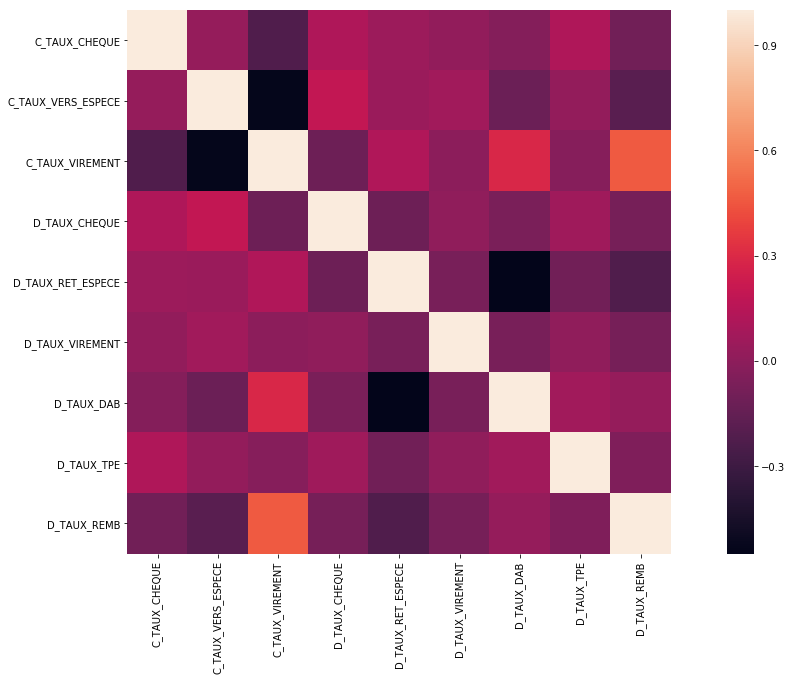

In [6]:
plt.figure(figsize=(20,10))
sns.heatmap(df_train.corr() , square = True)
plt.show()

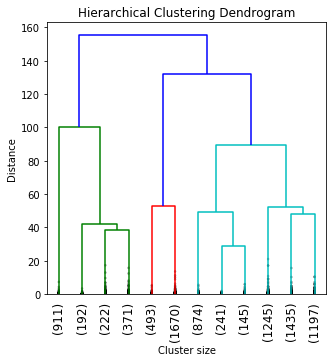

/home/nerifkh/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.41577070027390034

In [7]:
### hierarchical clustering
Z = cluster.hierarchy.ward(df_)
plt.figure(figsize=(5, 5))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster size')
plt.ylabel('Distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()
#cutree = cluster.hierarchy.cut_tree(Z, n_clusters=4)
#metrics.silhouette_score(df_,cutree)

k = 2
[0.43686702 1.         2.         3.         4.         5.
 6.         7.         8.        ]
k = 3
[0.43686702 0.40994175 2.         3.         4.         5.
 6.         7.         8.        ]
k = 4
[0.43686702 0.40994175 0.46519842 3.         4.         5.
 6.         7.         8.        ]
k = 5
[0.43686702 0.40994175 0.46519842 0.44811369 4.         5.
 6.         7.         8.        ]
k = 6
[0.43686702 0.40994175 0.46519842 0.44811369 0.44975253 5.
 6.         7.         8.        ]
k = 7
[0.43686702 0.40994175 0.46519842 0.44811369 0.44975253 0.46901903
 6.         7.         8.        ]
k = 8
[0.43686702 0.40994175 0.46519842 0.44811369 0.44975253 0.46901903
 0.45768061 7.         8.        ]
k = 9
[0.43686702 0.40994175 0.46519842 0.44811369 0.44975253 0.46901903
 0.45768061 0.46041913 8.        ]
k = 10
[0.43686702 0.40994175 0.46519842 0.44811369 0.44975253 0.46901903
 0.45768061 0.46041913 0.48669912]


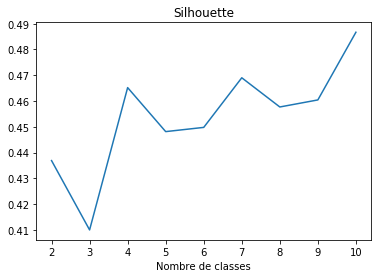

In [8]:
res = np.arange(9,dtype="double")
for k in np.arange(9):
    km=sk_cluster.KMeans(n_clusters=k+2)
    km.fit(df_)
    print("k =",k+2)
    res[k] = metrics.silhouette_score(df_,km.labels_)
    print(res)
# Graphique nombre optimal de classe (Silhouette )
plt.title("Silhouette")
plt.xlabel("Nombre de classes")
plt.plot(np.arange(2,11,1),res)
plt.show()

In [9]:
km = sk_cluster.KMeans(n_clusters=7)
km.fit(df_)
labels = km.predict(df_)
labels= pd.DataFrame(labels,columns=['SEGMENT'])
cent = km.cluster_centers_
df_.reset_index(drop=True, inplace=True)
frames = [df_, labels]
resultatKm = pd.concat(frames, axis=1)
list(resultatKm)
metrics.silhouette_score(df_,labels)

/home/nerifkh/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.46900324606373045

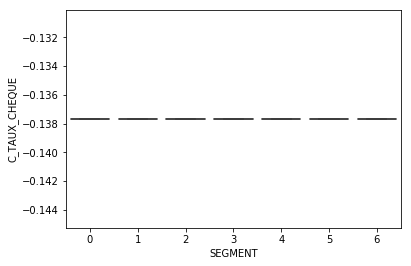

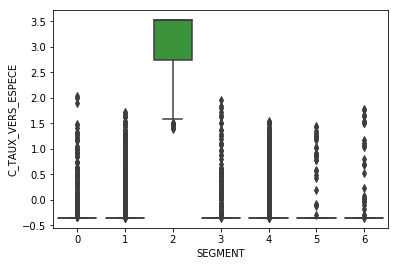

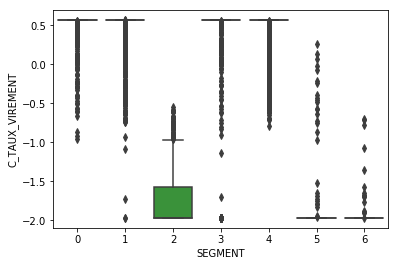

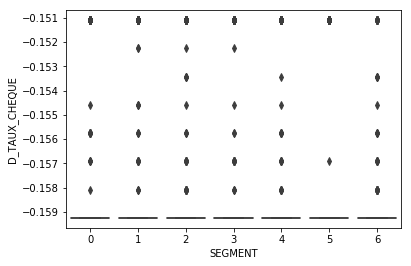

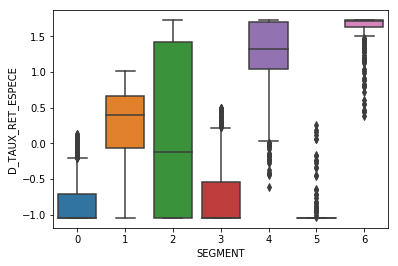

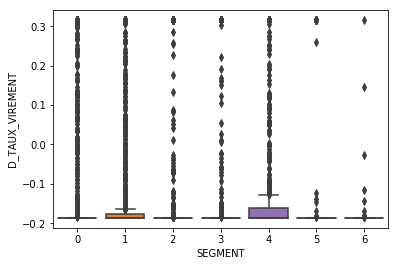

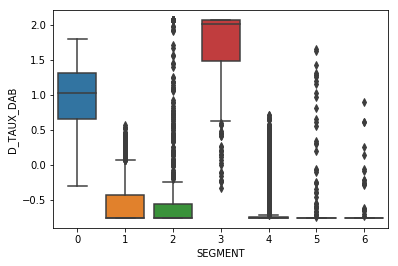

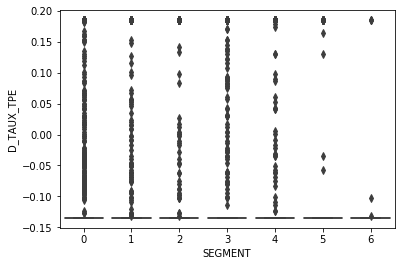

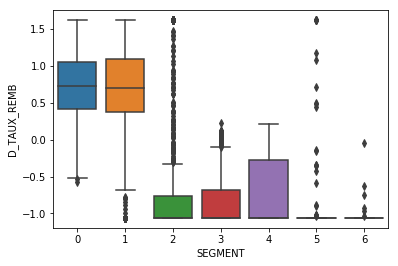

In [10]:
for col in df_.columns:
    sns.boxplot(x="SEGMENT", y=col, data=resultatKm)
    plt.show()

In [11]:
km = sk_cluster.KMeans(n_clusters=4)
km.fit(df_)
labels = km.predict(df_)
labels= pd.DataFrame(labels,columns=['SEGMENT'])
cent = km.cluster_centers_
df_.reset_index(drop=True, inplace=True)
frames = [df_, labels]
resultatKm = pd.concat(frames, axis=1)
list(resultatKm)
metrics.silhouette_score(df_,labels)

/home/nerifkh/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.4651984220382181

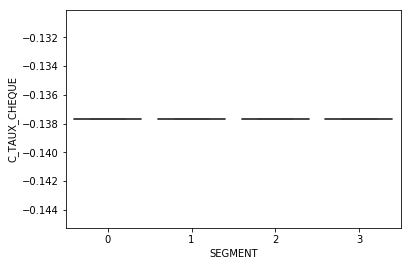

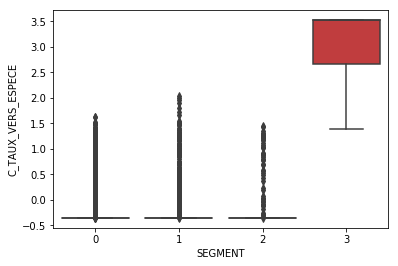

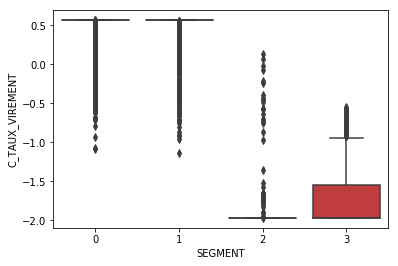

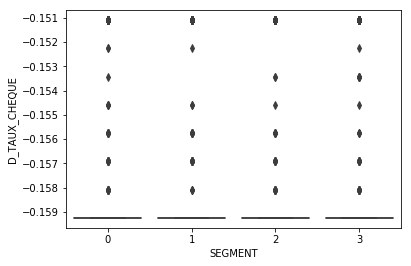

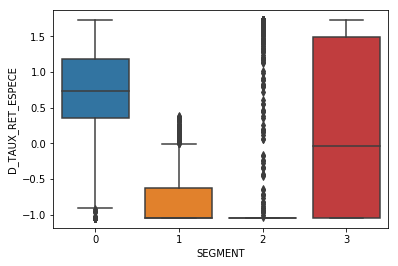

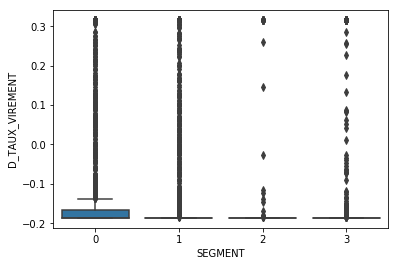

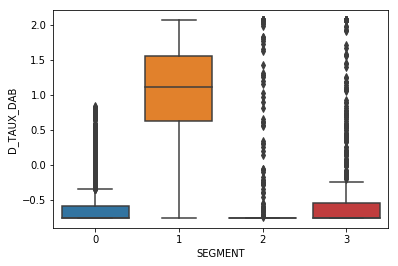

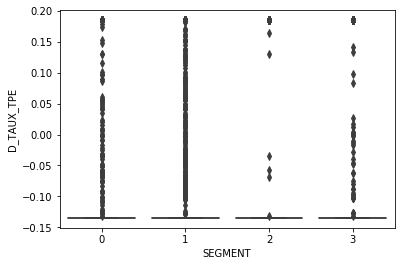

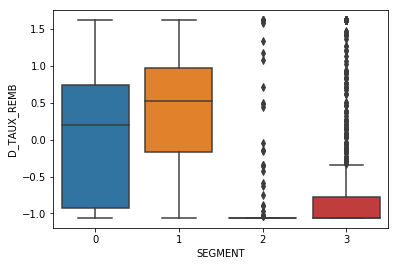

In [12]:
for col in df_.columns:
    sns.boxplot(x="SEGMENT", y=col, data=resultatKm)
    plt.show()

In [26]:
salaire=data["REVENU"].unique()
salaire.sort()
rg={}
i=0
for s in salaire:
    rg.update({s:i})
    i+=1
rg_col = []
for row in data["REVENU"]:
    rg_col.append(rg[row])
data["RG"] = rg_col

In [51]:
rdep=[]
for i in range(len(data)):
    if data["D_MNT"][i] == 0 or data["REVENU"][i] == 0:
        rdep.append(0)
    else:
        rdep.append(round(data["D_MNT"][i]/data["REVENU"][i], 4)*100)
data["RDEP"] = rdep

In [55]:
df__ = data[["C_TAUX_CHEQUE", "C_TAUX_VERS_ESPECE", "C_TAUX_VIREMENT", "D_TAUX_CHEQUE",
           "D_TAUX_RET_ESPECE", "D_TAUX_VIREMENT", "D_TAUX_DAB", "D_TAUX_TPE", "D_TAUX_REMB", "RDEP", "RG"]]

df_train, df_test = train_test_split(df__, test_size=0.1, random_state=50) 
scaler = StandardScaler()
scaler.fit(df_train)
X_ = scaler.transform(df_train)
df_x=pd.DataFrame(X_)
df_x.columns=["C_TAUX_CHEQUE", "C_TAUX_VERS_ESPECE", "C_TAUX_VIREMENT", "D_TAUX_CHEQUE",
           "D_TAUX_RET_ESPECE", "D_TAUX_VIREMENT", "D_TAUX_DAB", "D_TAUX_TPE", "D_TAUX_REMB", "RDEP", "RG"]

df_ = winsorize_df(df_x)

k = 2
[0.40672723 1.         2.         3.         4.         5.
 6.         7.         8.        ]
k = 3
[0.40672723 0.33365118 2.         3.         4.         5.
 6.         7.         8.        ]
k = 4
[0.40672723 0.33365118 0.38588743 3.         4.         5.
 6.         7.         8.        ]
k = 5
[0.40672723 0.33365118 0.38588743 0.34280535 4.         5.
 6.         7.         8.        ]
k = 6
[0.40672723 0.33365118 0.38588743 0.34280535 0.36227837 5.
 6.         7.         8.        ]
k = 7
[0.40672723 0.33365118 0.38588743 0.34280535 0.36227837 0.37229722
 6.         7.         8.        ]
k = 8
[0.40672723 0.33365118 0.38588743 0.34280535 0.36227837 0.37229722
 0.37873156 7.         8.        ]
k = 9
[0.40672723 0.33365118 0.38588743 0.34280535 0.36227837 0.37229722
 0.37873156 0.39575533 8.        ]
k = 10
[0.40672723 0.33365118 0.38588743 0.34280535 0.36227837 0.37229722
 0.37873156 0.39575533 0.38250031]


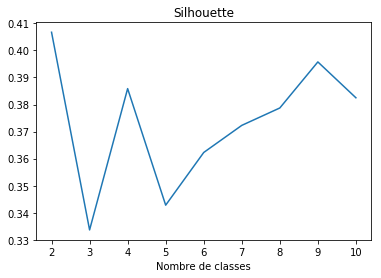

In [56]:
res = np.arange(9,dtype="double")
for k in np.arange(9):
    km=sk_cluster.KMeans(n_clusters=k+2)
    km.fit(df_)
    print("k =",k+2)
    res[k] = metrics.silhouette_score(df_,km.labels_)
    print(res)
# Graphique nombre optimal de classe (Silhouette )
plt.title("Silhouette")
plt.xlabel("Nombre de classes")
plt.plot(np.arange(2,11,1),res)
plt.show()

In [58]:
km = sk_cluster.KMeans(n_clusters=4)
km.fit(df_)
labels = km.predict(df_)
labels= pd.DataFrame(labels,columns=['SEGMENT'])
cent = km.cluster_centers_
df_.reset_index(drop=True, inplace=True)
frames = [df_, labels]
resultatKm = pd.concat(frames, axis=1)
list(resultatKm)
metrics.silhouette_score(df_,labels)

/home/nerifkh/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.3858370579131714

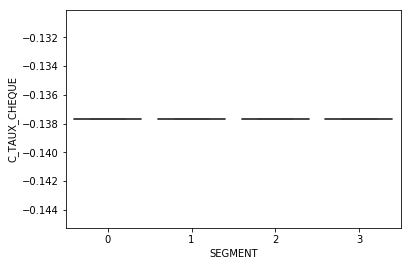

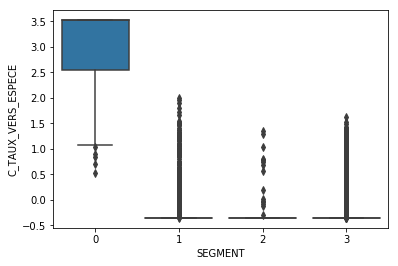

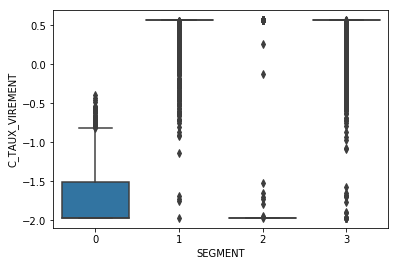

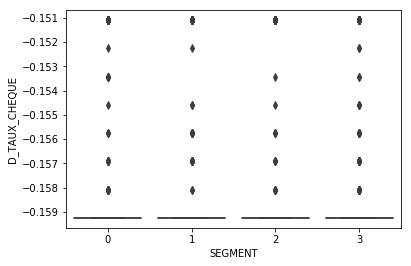

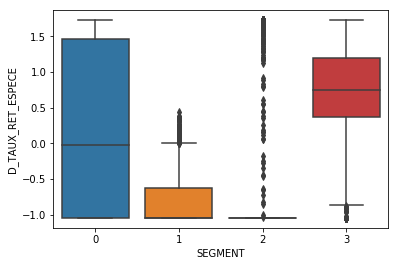

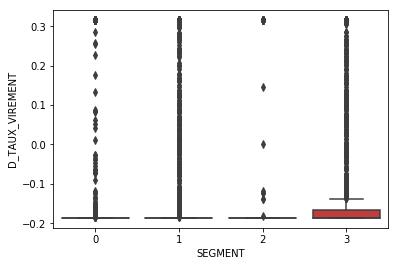

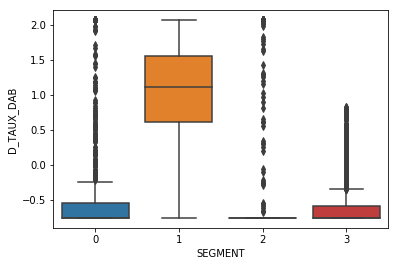

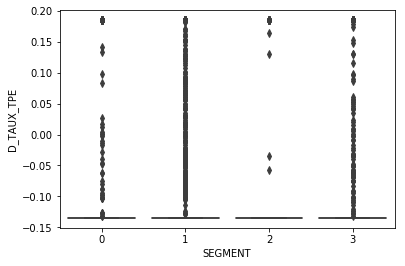

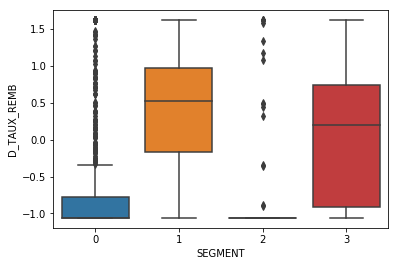

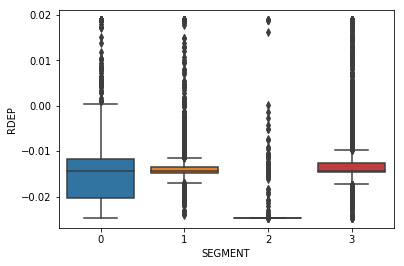

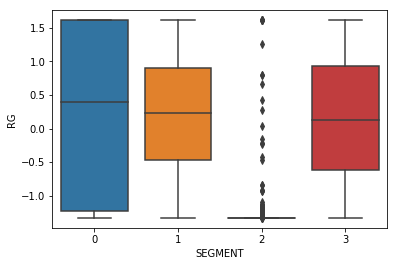

In [59]:
for col in df_.columns:
    sns.boxplot(x="SEGMENT", y=col, data=resultatKm)
    plt.show()